In [1]:
import numpy as np
import pandas as pd
import scipy.stats

pd.options.mode.chained_assignment = None
from matplotlib import pyplot as plt, rcParams
# import cv2
import seaborn as sns

sns.set(style="white", context="paper")
from cycler import cycler
import os, sys
import glob
from datetime import datetime, timedelta
from itertools import combinations
import base64
from PIL import Image
from io import BytesIO as _BytesIO
import requests
import json
import pickle
from datetime import datetime
from IPython.display import display, Markdown, Latex
from sklearn.metrics import *
import collections
from copy import deepcopy
import traceback
from sympy import Point, Polygon
import mmcv
import cv2
from mmtrack.apis import inference_mot, init_model as init_tracking_model
from smartprint import smartprint as sprint

pd.options.display.max_columns = None
def printm(s): return display(Markdown(s))
    
SERVER_CACHE_DIR = '/mnt/ci-nas-cache/edulyzeV2/cache_compute_4/fixed_face'
os.makedirs(SERVER_CACHE_DIR,exist_ok=True)

track_analysis_meta_cache = f'{SERVER_CACHE_DIR}/analysis_tracking/meta_info'
os.makedirs(track_analysis_meta_cache,exist_ok=True)
base_dir = '/mnt/ci-nas-cache/edulyzeV2/pose_face_gaze_emb_fixed_face'

track_analysis_session_data = f'{SERVER_CACHE_DIR}/analysis_tracking/session_tracking_info'
os.makedirs(track_analysis_session_data,exist_ok=True)

postprocessed_id_map_data_dir = f'{SERVER_CACHE_DIR}/analysis_tracking/processed_id_maps'
os.makedirs(postprocessed_id_map_data_dir, exist_ok=True)

id_viz_cache_root = f'{SERVER_CACHE_DIR}/analysis_tracking/session_matching_info'
os.makedirs(id_viz_cache_root, exist_ok=True)


/home/prasoon/anaconda3/envs/edusense/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/prasoon/anaconda3/envs/edusense/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/prasoon/anaconda3/envs/edusense/lib/python3.9/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


In [2]:
session_filter_list = [
 'classinsight-cmu_05681A_ghc_4301_201905011630',
 'classinsight-cmu_05681A_ghc_4301_201904171630',
 'classinsight-cmu_05681A_ghc_4301_201902201630',
 'classinsight-cmu_05681A_ghc_4301_201904101630',
 'classinsight-cmu_05681A_ghc_4301_201901231630',
 # 'classinsight-cmu_05418A_ghc_4102_201902251200',
 # 'classinsight-cmu_05418A_ghc_4102_201904081200',
 # 'classinsight-cmu_05418A_ghc_4102_201905011200',
 # 'classinsight-cmu_05418A_ghc_4102_201904291200',
 # 'classinsight-cmu_05418A_ghc_4102_201904011200',
 # 'classinsight-cmu_05748A_ghc_4101_201902141630',
 # 'classinsight-cmu_05748A_ghc_4101_201904021630',
 # 'classinsight-cmu_05748A_ghc_4101_201902051630',
 # 'classinsight-cmu_05748A_ghc_4101_201902281630',
 # 'classinsight-cmu_05748A_ghc_4101_201903071630',
 # 'classinsight-cmu_21127J_ghc_4102_201904230930',
 # 'classinsight-cmu_21127J_ghc_4102_201903260930',
 # 'classinsight-cmu_21127J_ghc_4102_201904160930',
 # 'classinsight-cmu_21127J_ghc_4102_201904300930',
 # 'classinsight-cmu_21127J_ghc_4102_201903190930',
 # 'classinsight-cmu_05410A_ghc_4301_201904151500',
 # 'classinsight-cmu_05410A_ghc_4301_201902251500',
 # 'classinsight-cmu_05410A_ghc_4301_201904081500',
 # 'classinsight-cmu_05410A_ghc_4301_201904221500',
 # 'classinsight-cmu_05410A_ghc_4301_201902181500',
                       
 # 'classinsight-cmu_17214B_ph_a21_201902271030',
 # 'classinsight-cmu_17214B_ph_a21_201903061030',
 # 'classinsight-cmu_17214B_ph_a21_201904031030',
 # 'classinsight-cmu_17214B_ph_a21_201904101030',
 # 'classinsight-cmu_17214B_ph_a21_201904241030',
 # 'classinsight-cmu_17214C_ph_225b_201903201130',
 # 'classinsight-cmu_17214C_ph_225b_201904101130',
 # 'classinsight-cmu_17214C_ph_225b_201904171130',
 # 'classinsight-cmu_17214C_ph_225b_201904241130',
 # 'classinsight-cmu_17214C_ph_225b_201905011130',
 # 'classinsight-cmu_05410B_ghc_4211_201902111500',
 # 'classinsight-cmu_05410B_ghc_4211_201903181500',
 # 'classinsight-cmu_05410B_ghc_4211_201904081500',
 # 'classinsight-cmu_05410B_ghc_4211_201904151500',
 # 'classinsight-cmu_05410B_ghc_4211_201904221500',
 # 'classinsight-cmu_05410B_ghc_4211_201901281500'
]

# Cache and get tracking information for sessions

## Get frame file data for all sessions

In [3]:

frame_file_data = {}
for course_idx, course_dir in enumerate(glob.glob(f"{base_dir}/*")):
    course_name = course_dir.split("/")[-1]
    course_cache_file = f"{track_analysis_meta_cache}/{course_name}"
    if os.path.exists(course_cache_file):
        frame_file_data[course_name] = pickle.load(open(course_cache_file,"rb"))
        continue
    frame_file_data[course_name]={}
        
    for session_idx, session_dir in enumerate(glob.glob(f"{course_dir}/*")):
        session_name = session_dir.split("/")[-1]
        frame_file_data[course_name][session_name] = {}
        frame_files = glob.glob(f"{session_dir}/*")
        frame_file_names = [xr.split("/")[-1] for xr in frame_files]
        if 'end.pb' in frame_file_names:
            frame_file_data[course_name][session_name]['is_completed']=True
        else:
            frame_file_data[course_name][session_name]['is_completed']=False            
        frame_ids = [int(xr.split(".")[0]) for xr in frame_file_names if not (xr=='end.pb')]
        frame_file_data[course_name][session_name]['frame_ids'] = sorted(frame_ids)
        frame_file_data[course_name][session_name]['dir_location'] = session_dir
        print(f"Got metadata for course: {course_idx}-{course_name}, session:{session_idx}-{session_name}")
    pickle.dump(frame_file_data[course_name],open(course_cache_file,"wb")) 
        
        
frame_file_data.keys()

dict_keys(['05748A', '05410B', '17214C', '17214B', '05681A', '24352A', '24352C', '86375A'])

## Collect tracking data for all sessions

In [4]:
# writing a generic loop to get only-tracking info from all courses in frame file data, but putting a filter ahead

for course_idx, course in enumerate(frame_file_data):
    for session_idx, session_id in enumerate(frame_file_data[course]):
        session_tracking_cache_file = f"{track_analysis_session_data}/{session_id}.pb"
        # if session_id.split("-front")[0] not in session_filter_list:
        #     print(f"Session {session_id} not in session filter list, skipping...")
        #     continue
        try:
a                print(f"Got tracking info for session: {course_idx}-{course}, session:{session_idx}-{session_id}")
            else:
                ...
                print(f"FILE EXISTS: tracking info for session: {course_idx}-{course}, session:{session_idx}-{session_id}")
        except:
            print(f"ERROR: Unable to get session tracking for: {course_idx}-{course}, session:{session_idx}-{session_id}")
            unfinished_sessions.append((course, session_id))
            print(traceback.format_exc())
    

FILE EXISTS: tracking info for session: 0-05748A, session:0-classinsight-cmu_05748A_ghc_4101_201902051630-front
FILE EXISTS: tracking info for session: 0-05748A, session:1-classinsight-cmu_05748A_ghc_4101_201902141630-front
FILE EXISTS: tracking info for session: 0-05748A, session:2-classinsight-cmu_05748A_ghc_4101_201901291630-front
FILE EXISTS: tracking info for session: 0-05748A, session:3-classinsight-cmu_05748A_ghc_4101_201901311630-front
FILE EXISTS: tracking info for session: 0-05748A, session:4-classinsight-cmu_05748A_ghc_4101_201902071630-front
FILE EXISTS: tracking info for session: 0-05748A, session:5-classinsight-cmu_05748A_ghc_4101_201902121630-front
FILE EXISTS: tracking info for session: 0-05748A, session:6-classinsight-cmu_05748A_ghc_4101_201902191630-front
FILE EXISTS: tracking info for session: 0-05748A, session:7-classinsight-cmu_05748A_ghc_4101_201902211630-front
FILE EXISTS: tracking info for session: 0-05748A, session:8-classinsight-cmu_05748A_ghc_4101_20190228163

## Postprocess mmtrack results and create a new tracking map from older tracking ids

### Run id filtering and mapping for all sessions

In [5]:

for course_idx, course in enumerate(frame_file_data):
    for session_idx, session_id in enumerate(frame_file_data[course]):
        session_preprocessed_id_map_file = f"{postprocessed_id_map_data_dir}/{session_id}.pb"
        if not os.path.exists(session_preprocessed_id_map_file):
            session_tracking_cache_file = f"{track_analysis_session_data}/{session_id}.pb"
            session_frame_dir = f'/mnt/ci-nas-cache/edulyzeV2/pose_face_gaze_emb_fixed_face/{course}/{session_id}'
            if not os.path.exists(session_tracking_cache_file):
                printm(f"## Tracking file does not exists for session {session_id}, skipping id-matching...")
                continue
            
            df_tracking = pickle.load(open(session_tracking_cache_file,"rb")).transpose()
            printm(f'# {course_idx}-{course}, session:{session_idx}-{session_id}')
            printm(f'## Raw tracking shape:{df_tracking.shape}')
            printm(f'## Filter non-persistentids')
            MIN_ID_FRAMES = 900 # number of frames an id needs to be a persistent id
            col_start_stop_idxs = []
            for col in df_tracking.columns:
                one_idxs = df_tracking.index[np.where(df_tracking[col]==1)[0]].values
                col_start_stop_idxs.append([col, one_idxs.min(), one_idxs.max()])
            df_id_start_stop = pd.DataFrame(col_start_stop_idxs, columns=['id','min_idx','max_idx'])
            df_id_start_stop['total_idxs'] = df_id_start_stop['max_idx']-df_id_start_stop['min_idx']
            nonpersistent_ids_removed = df_id_start_stop[df_id_start_stop.total_idxs<=MIN_ID_FRAMES]['id'].values
            printm(f'### Total ids before filtering: {df_id_start_stop.shape[0]}')
            df_id_start_stop = df_id_start_stop[df_id_start_stop.total_idxs>MIN_ID_FRAMES].reset_index(drop=True)
            printm(f'### Total ids after filtering: {df_id_start_stop.shape[0]}')
            
            printm(f'## Map ids into one based on bbox overlap and id start/stop distance')
            MAX_ID_DISTANCE = 900
            MAX_BBOX_OVERLAP = 0.4
            
            potential_id_maps = {}
            num_possible_maps = 0 
            for row_idx, row in df_id_start_stop.iterrows():
                row_maxidx = row['max_idx']
                
                # get polygon for given id
                id_max_frame = row_maxidx
                id_frame_data = pickle.load(open(f"{session_frame_dir}/{id_max_frame}.pb","rb"))[1]
                id_frame_data = [xr for xr in id_frame_data if (xr['track_id']==row['id'])][0]
                id_bb = id_frame_data['bbox'][:4].astype(int)
                X_TL1, Y_TL1, X_BR1, Y_BR1 = id_bb
                p1, p2, p3, p4  = map(Point, [[X_TL1,Y_TL1], [X_TL1,Y_BR1], [X_BR1,Y_BR1],[X_BR1, Y_TL1]]) 
                id_polygon = Polygon(p1, p2, p3, p4)
                
                potential_id_matches = df_id_start_stop[(df_id_start_stop.min_idx<=row_maxidx+MAX_ID_DISTANCE) & (df_id_start_stop.min_idx>row_maxidx-MAX_ID_DISTANCE)].id.values
                successful_matches = []
                if len(potential_id_matches)>0:
                    num_possible_maps+=1
                    # print('\n',row['id'], potential_id_matches, row['min_idx'],row['max_idx'],row['total_idxs'])
                    for matched_id in potential_id_matches:
                        matched_id_min_frame = df_id_start_stop[df_id_start_stop.id==matched_id].min_idx.values[0]
                        matched_id_frame_data = pickle.load(open(f"{session_frame_dir}/{matched_id_min_frame}.pb","rb"))[1]
                        matched_id_frame_data = [xr for xr in matched_id_frame_data if (xr['track_id']==matched_id)][0]
                        matched_id_bb = matched_id_frame_data['bbox'][:4].astype(int)
                        X_TL2, Y_TL2, X_BR2, Y_BR2 = matched_id_bb
                        
                        p1, p2, p3, p4  = map(Point, [[X_TL2,Y_TL2], [X_TL2,Y_BR2], [X_BR2,Y_BR2],[X_BR2, Y_TL2]]) 
                        matched_id_polygon = Polygon(p1, p2, p3, p4)
                        
                        #find intersection of two polygons
                        # check if intersection exists
                        if id_polygon.encloses_point(matched_id_polygon.centroid) & matched_id_polygon.encloses_point(id_polygon.centroid):
                            X_TL_in, X_BR_in = sorted([X_TL1,X_TL2, X_BR1, X_BR2])[1:3]
                            Y_TL_in, Y_BR_in = sorted([Y_TL1,Y_TL2, Y_BR1, Y_BR2])[1:3]
                            p1, p2, p3, p4  = map(Point, [[X_TL_in,Y_TL_in], [X_TL_in,Y_BR_in], [X_BR_in,Y_BR_in],[X_BR_in, Y_TL_in]]) 
                            intersection = Polygon(p1, p2, p3, p4)            
            
                            #find polygon overlap
                            area_intersection = np.abs(intersection.area)
                            area_union = np.abs(id_polygon.area) + np.abs(matched_id_polygon.area) - area_intersection
                            overlap_fraction  = (area_intersection/area_union).evalf()
                        else:
                            overlap_fraction=0.            
                        if overlap_fraction > MAX_BBOX_OVERLAP:
                            successful_matches.append((matched_id, overlap_fraction))
                        
                        # print('\tMatching Id: ', matched_id,':', 'frame:',matched_id_min_frame,'overlap_fraction:', overlap_fraction)
                if len(successful_matches) > 0:
                    successful_matched_id = sorted(successful_matches, key=lambda x: x[1])[-1][0]
                    # print(row['id'], '-->Successful match to-->',successful_matched_id)
                    if row['id'] in potential_id_maps.keys():
                        potential_id_maps[successful_matched_id] = potential_id_maps[row['id']]
                    else:
                        potential_id_maps[successful_matched_id] = row['id']
            
            matched_ids  = list(potential_id_maps.keys())
            df_id_start_stop =  df_id_start_stop[~df_id_start_stop['id'].isin(matched_ids)].sort_values(by='id').reset_index(drop=True)
            printm(f'### Total ids after mapping: {df_id_start_stop.shape[0]}')
            
            printm(f'## Assign new ids to final set of postprocessed ids')
            new_to_old_id_map = df_id_start_stop['id'].to_dict()
            old_to_new_id_map = {v: k for k, v in new_to_old_id_map.items()}
            
            for matched_id in matched_ids:
                old_to_new_id_map[matched_id] = old_to_new_id_map[potential_id_maps[matched_id]]
            
            for removed_id in nonpersistent_ids_removed:
                old_to_new_id_map[removed_id] = 10000
            
            pickle.dump(old_to_new_id_map, open(session_preprocessed_id_map_file,"wb"))
            printm(f"## Created ID Map for session: {course_idx}-{course}, session:{session_idx}-{session_id} from {len(old_to_new_id_map.keys())} to {df_id_start_stop.shape[0]} ids")
        else:
            printm(f"## FILE EXISTS: ID Map for session: {course_idx}-{course}, session:{session_idx}-{session_id}")
            
        
        

## FILE EXISTS: ID Map for session: 0-05748A, session:0-classinsight-cmu_05748A_ghc_4101_201902051630-front

## FILE EXISTS: ID Map for session: 0-05748A, session:1-classinsight-cmu_05748A_ghc_4101_201902141630-front

# 0-05748A, session:2-classinsight-cmu_05748A_ghc_4101_201901291630-front

## Raw tracking shape:(11870, 666)

## Filter non-persistentids

### Total ids before filtering: 666

### Total ids after filtering: 52

## Map ids into one based on bbox overlap and id start/stop distance

### Total ids after mapping: 33

## Assign new ids to final set of postprocessed ids

## Created ID Map for session: 0-05748A, session:2-classinsight-cmu_05748A_ghc_4101_201901291630-front from 666 to 33 ids

# 0-05748A, session:3-classinsight-cmu_05748A_ghc_4101_201901311630-front

## Raw tracking shape:(11933, 4)

## Filter non-persistentids

### Total ids before filtering: 4

### Total ids after filtering: 0

## Map ids into one based on bbox overlap and id start/stop distance

### Total ids after mapping: 0

## Assign new ids to final set of postprocessed ids

## Created ID Map for session: 0-05748A, session:3-classinsight-cmu_05748A_ghc_4101_201901311630-front from 4 to 0 ids

# 0-05748A, session:4-classinsight-cmu_05748A_ghc_4101_201902071630-front

## Raw tracking shape:(11909, 1335)

## Filter non-persistentids

### Total ids before filtering: 1335

### Total ids after filtering: 53

## Map ids into one based on bbox overlap and id start/stop distance

### Total ids after mapping: 37

## Assign new ids to final set of postprocessed ids

## Created ID Map for session: 0-05748A, session:4-classinsight-cmu_05748A_ghc_4101_201902071630-front from 1335 to 37 ids

# 0-05748A, session:5-classinsight-cmu_05748A_ghc_4101_201902121630-front

## Raw tracking shape:(5260, 177)

## Filter non-persistentids

### Total ids before filtering: 177

### Total ids after filtering: 30

## Map ids into one based on bbox overlap and id start/stop distance

### Total ids after mapping: 21

## Assign new ids to final set of postprocessed ids

## Created ID Map for session: 0-05748A, session:5-classinsight-cmu_05748A_ghc_4101_201902121630-front from 177 to 21 ids

# 0-05748A, session:6-classinsight-cmu_05748A_ghc_4101_201902191630-front

## Raw tracking shape:(5276, 360)

## Filter non-persistentids

### Total ids before filtering: 360

### Total ids after filtering: 26

## Map ids into one based on bbox overlap and id start/stop distance

### Total ids after mapping: 21

## Assign new ids to final set of postprocessed ids

## Created ID Map for session: 0-05748A, session:6-classinsight-cmu_05748A_ghc_4101_201902191630-front from 360 to 21 ids

# 0-05748A, session:7-classinsight-cmu_05748A_ghc_4101_201902211630-front

## Raw tracking shape:(23889, 1162)

## Filter non-persistentids

### Total ids before filtering: 1162

### Total ids after filtering: 47

## Map ids into one based on bbox overlap and id start/stop distance

### Total ids after mapping: 32

## Assign new ids to final set of postprocessed ids

## Created ID Map for session: 0-05748A, session:7-classinsight-cmu_05748A_ghc_4101_201902211630-front from 1162 to 32 ids

## FILE EXISTS: ID Map for session: 0-05748A, session:8-classinsight-cmu_05748A_ghc_4101_201902281630-front

# 0-05748A, session:9-classinsight-cmu_05748A_ghc_4101_201903051630-front

## Raw tracking shape:(21895, 1698)

## Filter non-persistentids

### Total ids before filtering: 1698

### Total ids after filtering: 21

## Map ids into one based on bbox overlap and id start/stop distance

### Total ids after mapping: 17

## Assign new ids to final set of postprocessed ids

## Created ID Map for session: 0-05748A, session:9-classinsight-cmu_05748A_ghc_4101_201903051630-front from 1698 to 17 ids

## FILE EXISTS: ID Map for session: 0-05748A, session:10-classinsight-cmu_05748A_ghc_4101_201903071630-front

# 0-05748A, session:11-classinsight-cmu_05748A_ghc_4101_201903121630-front

## Raw tracking shape:(22290, 78)

## Filter non-persistentids

### Total ids before filtering: 78

### Total ids after filtering: 1

## Map ids into one based on bbox overlap and id start/stop distance

### Total ids after mapping: 1

## Assign new ids to final set of postprocessed ids

## Created ID Map for session: 0-05748A, session:11-classinsight-cmu_05748A_ghc_4101_201903121630-front from 78 to 1 ids

# 0-05748A, session:12-classinsight-cmu_05748A_ghc_4101_201903141630-front

## Raw tracking shape:(5600, 19)

## Filter non-persistentids

### Total ids before filtering: 19

### Total ids after filtering: 1

## Map ids into one based on bbox overlap and id start/stop distance

### Total ids after mapping: 1

## Assign new ids to final set of postprocessed ids

## Created ID Map for session: 0-05748A, session:12-classinsight-cmu_05748A_ghc_4101_201903141630-front from 19 to 1 ids

# 0-05748A, session:13-classinsight-cmu_05748A_ghc_4101_201903191630-front

## Raw tracking shape:(5671, 1)

## Filter non-persistentids

### Total ids before filtering: 1

### Total ids after filtering: 0

## Map ids into one based on bbox overlap and id start/stop distance

### Total ids after mapping: 0

## Assign new ids to final set of postprocessed ids

## Created ID Map for session: 0-05748A, session:13-classinsight-cmu_05748A_ghc_4101_201903191630-front from 1 to 0 ids

# 0-05748A, session:14-classinsight-cmu_05748A_ghc_4101_201903211630-front

## Raw tracking shape:(22051, 144)

## Filter non-persistentids

### Total ids before filtering: 144

### Total ids after filtering: 2

## Map ids into one based on bbox overlap and id start/stop distance

### Total ids after mapping: 2

## Assign new ids to final set of postprocessed ids

## Created ID Map for session: 0-05748A, session:14-classinsight-cmu_05748A_ghc_4101_201903211630-front from 144 to 2 ids

# 0-05748A, session:15-classinsight-cmu_05748A_ghc_4101_201903261630-front

## Raw tracking shape:(5727, 148)

## Filter non-persistentids

### Total ids before filtering: 148

### Total ids after filtering: 26

## Map ids into one based on bbox overlap and id start/stop distance

### Total ids after mapping: 20

## Assign new ids to final set of postprocessed ids

## Created ID Map for session: 0-05748A, session:15-classinsight-cmu_05748A_ghc_4101_201903261630-front from 148 to 20 ids

# 0-05748A, session:16-classinsight-cmu_05748A_ghc_4101_201903281630-front

## Raw tracking shape:(3750, 102)

## Filter non-persistentids

### Total ids before filtering: 102

### Total ids after filtering: 23

## Map ids into one based on bbox overlap and id start/stop distance

### Total ids after mapping: 19

## Assign new ids to final set of postprocessed ids

## Created ID Map for session: 0-05748A, session:16-classinsight-cmu_05748A_ghc_4101_201903281630-front from 102 to 19 ids

## FILE EXISTS: ID Map for session: 0-05748A, session:17-classinsight-cmu_05748A_ghc_4101_201904021630-front

# 0-05748A, session:18-classinsight-cmu_05748A_ghc_4101_201904041630-front

## Raw tracking shape:(24000, 492)

## Filter non-persistentids

### Total ids before filtering: 492

### Total ids after filtering: 43

## Map ids into one based on bbox overlap and id start/stop distance

### Total ids after mapping: 30

## Assign new ids to final set of postprocessed ids

## Created ID Map for session: 0-05748A, session:18-classinsight-cmu_05748A_ghc_4101_201904041630-front from 492 to 30 ids

# 0-05748A, session:19-classinsight-cmu_05748A_ghc_4101_201904091630-front

## Raw tracking shape:(24001, 1800)

## Filter non-persistentids

### Total ids before filtering: 1800

### Total ids after filtering: 59

## Map ids into one based on bbox overlap and id start/stop distance

### Total ids after mapping: 37

## Assign new ids to final set of postprocessed ids

## Created ID Map for session: 0-05748A, session:19-classinsight-cmu_05748A_ghc_4101_201904091630-front from 1800 to 37 ids

# 0-05748A, session:20-classinsight-cmu_05748A_ghc_4101_201904111630-front

## Raw tracking shape:(23999, 5)

## Filter non-persistentids

### Total ids before filtering: 5

### Total ids after filtering: 0

## Map ids into one based on bbox overlap and id start/stop distance

### Total ids after mapping: 0

## Assign new ids to final set of postprocessed ids

## Created ID Map for session: 0-05748A, session:20-classinsight-cmu_05748A_ghc_4101_201904111630-front from 5 to 0 ids

# 0-05748A, session:21-classinsight-cmu_05748A_ghc_4101_201904161630-front

## Raw tracking shape:(10050, 717)

## Filter non-persistentids

### Total ids before filtering: 717

### Total ids after filtering: 37

## Map ids into one based on bbox overlap and id start/stop distance

### Total ids after mapping: 30

## Assign new ids to final set of postprocessed ids

## Created ID Map for session: 0-05748A, session:21-classinsight-cmu_05748A_ghc_4101_201904161630-front from 717 to 30 ids

# 0-05748A, session:22-classinsight-cmu_05748A_ghc_4101_201904181630-front

## Raw tracking shape:(23998, 1211)

## Filter non-persistentids

### Total ids before filtering: 1211

### Total ids after filtering: 64

## Map ids into one based on bbox overlap and id start/stop distance

### Total ids after mapping: 38

## Assign new ids to final set of postprocessed ids

## Created ID Map for session: 0-05748A, session:22-classinsight-cmu_05748A_ghc_4101_201904181630-front from 1211 to 38 ids

# 0-05748A, session:23-classinsight-cmu_05748A_ghc_4101_201904231630-front

## Raw tracking shape:(23999, 817)

## Filter non-persistentids

### Total ids before filtering: 817

### Total ids after filtering: 52

## Map ids into one based on bbox overlap and id start/stop distance

### Total ids after mapping: 32

## Assign new ids to final set of postprocessed ids

## Created ID Map for session: 0-05748A, session:23-classinsight-cmu_05748A_ghc_4101_201904231630-front from 817 to 32 ids

# 0-05748A, session:24-classinsight-cmu_05748A_ghc_4101_201901241630-front

## Raw tracking shape:(23911, 2699)

## Filter non-persistentids

### Total ids before filtering: 2699

### Total ids after filtering: 85

## Map ids into one based on bbox overlap and id start/stop distance

### Total ids after mapping: 46

## Assign new ids to final set of postprocessed ids

## Created ID Map for session: 0-05748A, session:24-classinsight-cmu_05748A_ghc_4101_201901241630-front from 2699 to 46 ids

# 0-05748A, session:25-classinsight-cmu_05748A_ghc_4101_201904251630-front

## Raw tracking shape:(23998, 383)

## Filter non-persistentids

### Total ids before filtering: 383

### Total ids after filtering: 33

## Map ids into one based on bbox overlap and id start/stop distance

### Total ids after mapping: 25

## Assign new ids to final set of postprocessed ids

## Created ID Map for session: 0-05748A, session:25-classinsight-cmu_05748A_ghc_4101_201904251630-front from 383 to 25 ids

# 0-05748A, session:26-classinsight-cmu_05748A_ghc_4101_201904301630-front

## Raw tracking shape:(23999, 984)

## Filter non-persistentids

### Total ids before filtering: 984

### Total ids after filtering: 40

## Map ids into one based on bbox overlap and id start/stop distance

### Total ids after mapping: 29

## Assign new ids to final set of postprocessed ids

## Created ID Map for session: 0-05748A, session:26-classinsight-cmu_05748A_ghc_4101_201904301630-front from 984 to 29 ids

# 0-05748A, session:27-classinsight-cmu_05748A_ghc_4101_201905021630-front

## Raw tracking shape:(23999, 627)

## Filter non-persistentids

### Total ids before filtering: 627

### Total ids after filtering: 32

## Map ids into one based on bbox overlap and id start/stop distance

### Total ids after mapping: 20

## Assign new ids to final set of postprocessed ids

## Created ID Map for session: 0-05748A, session:27-classinsight-cmu_05748A_ghc_4101_201905021630-front from 627 to 20 ids

# 1-05410B, session:0-classinsight-cmu_05410B_ghc_4211_201901301500-front

## Raw tracking shape:(5318, 0)

## Filter non-persistentids

### Total ids before filtering: 0

### Total ids after filtering: 0

## Map ids into one based on bbox overlap and id start/stop distance

### Total ids after mapping: 0

## Assign new ids to final set of postprocessed ids

## Created ID Map for session: 1-05410B, session:0-classinsight-cmu_05410B_ghc_4211_201901301500-front from 0 to 0 ids

# 1-05410B, session:1-classinsight-cmu_05410B_ghc_4211_201902041500-front

## Raw tracking shape:(11878, 990)

## Filter non-persistentids

### Total ids before filtering: 990

### Total ids after filtering: 71

## Map ids into one based on bbox overlap and id start/stop distance

### Total ids after mapping: 43

## Assign new ids to final set of postprocessed ids

## Created ID Map for session: 1-05410B, session:1-classinsight-cmu_05410B_ghc_4211_201902041500-front from 990 to 43 ids

# 1-05410B, session:2-classinsight-cmu_05410B_ghc_4211_201902061500-front

## Raw tracking shape:(5272, 0)

## Filter non-persistentids

### Total ids before filtering: 0

### Total ids after filtering: 0

## Map ids into one based on bbox overlap and id start/stop distance

### Total ids after mapping: 0

## Assign new ids to final set of postprocessed ids

## Created ID Map for session: 1-05410B, session:2-classinsight-cmu_05410B_ghc_4211_201902061500-front from 0 to 0 ids

## FILE EXISTS: ID Map for session: 1-05410B, session:3-classinsight-cmu_05410B_ghc_4211_201902111500-front

# 1-05410B, session:4-classinsight-cmu_05410B_ghc_4211_201902131500-front

## Raw tracking shape:(5287, 4)

## Filter non-persistentids

### Total ids before filtering: 4

### Total ids after filtering: 0

## Map ids into one based on bbox overlap and id start/stop distance

### Total ids after mapping: 0

## Assign new ids to final set of postprocessed ids

## Created ID Map for session: 1-05410B, session:4-classinsight-cmu_05410B_ghc_4211_201902131500-front from 4 to 0 ids

# 1-05410B, session:5-classinsight-cmu_05410B_ghc_4211_201902181500-front

## Raw tracking shape:(23815, 1077)

## Filter non-persistentids

### Total ids before filtering: 1077

### Total ids after filtering: 46

## Map ids into one based on bbox overlap and id start/stop distance

### Total ids after mapping: 26

## Assign new ids to final set of postprocessed ids

## Created ID Map for session: 1-05410B, session:5-classinsight-cmu_05410B_ghc_4211_201902181500-front from 1077 to 26 ids

# 1-05410B, session:6-classinsight-cmu_05410B_ghc_4211_201902201512-front

## Raw tracking shape:(23890, 890)

## Filter non-persistentids

### Total ids before filtering: 890

### Total ids after filtering: 39

## Map ids into one based on bbox overlap and id start/stop distance

### Total ids after mapping: 29

## Assign new ids to final set of postprocessed ids

## Created ID Map for session: 1-05410B, session:6-classinsight-cmu_05410B_ghc_4211_201902201512-front from 890 to 29 ids

# 1-05410B, session:7-classinsight-cmu_05410B_ghc_4211_201902251500-front

## Raw tracking shape:(23869, 6089)

## Filter non-persistentids

### Total ids before filtering: 6089

### Total ids after filtering: 206

## Map ids into one based on bbox overlap and id start/stop distance

### Total ids after mapping: 143

## Assign new ids to final set of postprocessed ids

## Created ID Map for session: 1-05410B, session:7-classinsight-cmu_05410B_ghc_4211_201902251500-front from 6089 to 143 ids

# 1-05410B, session:8-classinsight-cmu_05410B_ghc_4211_201902271500-front

## Raw tracking shape:(491, 4)

## Filter non-persistentids

### Total ids before filtering: 4

### Total ids after filtering: 4

## Map ids into one based on bbox overlap and id start/stop distance

### Total ids after mapping: 4

## Assign new ids to final set of postprocessed ids

## Created ID Map for session: 1-05410B, session:8-classinsight-cmu_05410B_ghc_4211_201902271500-front from 4 to 4 ids

# 1-05410B, session:9-classinsight-cmu_05410B_ghc_4211_201903041500-front

## Raw tracking shape:(21911, 4938)

## Filter non-persistentids

### Total ids before filtering: 4938

### Total ids after filtering: 147

## Map ids into one based on bbox overlap and id start/stop distance

### Total ids after mapping: 68

## Assign new ids to final set of postprocessed ids

## Created ID Map for session: 1-05410B, session:9-classinsight-cmu_05410B_ghc_4211_201903041500-front from 4938 to 68 ids

# 1-05410B, session:10-classinsight-cmu_05410B_ghc_4211_201903111500-front

## Raw tracking shape:(5789, 61)

## Filter non-persistentids

### Total ids before filtering: 61

### Total ids after filtering: 0

## Map ids into one based on bbox overlap and id start/stop distance

### Total ids after mapping: 0

## Assign new ids to final set of postprocessed ids

## Created ID Map for session: 1-05410B, session:10-classinsight-cmu_05410B_ghc_4211_201903111500-front from 61 to 0 ids

# 1-05410B, session:11-classinsight-cmu_05410B_ghc_4211_201903131500-front

## Raw tracking shape:(22063, 51)

## Filter non-persistentids

### Total ids before filtering: 51

### Total ids after filtering: 1

## Map ids into one based on bbox overlap and id start/stop distance

### Total ids after mapping: 1

## Assign new ids to final set of postprocessed ids

## Created ID Map for session: 1-05410B, session:11-classinsight-cmu_05410B_ghc_4211_201903131500-front from 51 to 1 ids

## FILE EXISTS: ID Map for session: 1-05410B, session:12-classinsight-cmu_05410B_ghc_4211_201903181500-front

# 1-05410B, session:13-classinsight-cmu_05410B_ghc_4211_201903201500-front

## Raw tracking shape:(5808, 109)

## Filter non-persistentids

### Total ids before filtering: 109

### Total ids after filtering: 6

## Map ids into one based on bbox overlap and id start/stop distance

### Total ids after mapping: 5

## Assign new ids to final set of postprocessed ids

## Created ID Map for session: 1-05410B, session:13-classinsight-cmu_05410B_ghc_4211_201903201500-front from 109 to 5 ids

# 1-05410B, session:14-classinsight-cmu_05410B_ghc_4211_201903271500-front

## Raw tracking shape:(6197, 34)

## Filter non-persistentids

### Total ids before filtering: 34

### Total ids after filtering: 0

## Map ids into one based on bbox overlap and id start/stop distance

### Total ids after mapping: 0

## Assign new ids to final set of postprocessed ids

## Created ID Map for session: 1-05410B, session:14-classinsight-cmu_05410B_ghc_4211_201903271500-front from 34 to 0 ids

# 1-05410B, session:15-classinsight-cmu_05410B_ghc_4211_201904031500-front

## Raw tracking shape:(21148, 2)

## Filter non-persistentids

### Total ids before filtering: 2

### Total ids after filtering: 2

## Map ids into one based on bbox overlap and id start/stop distance

### Total ids after mapping: 2

## Assign new ids to final set of postprocessed ids

## Created ID Map for session: 1-05410B, session:15-classinsight-cmu_05410B_ghc_4211_201904031500-front from 2 to 2 ids

## FILE EXISTS: ID Map for session: 1-05410B, session:16-classinsight-cmu_05410B_ghc_4211_201904081500-front

# 1-05410B, session:17-classinsight-cmu_05410B_ghc_4211_201904101500-front

## Raw tracking shape:(24002, 3)

## Filter non-persistentids

### Total ids before filtering: 3

### Total ids after filtering: 1

## Map ids into one based on bbox overlap and id start/stop distance

### Total ids after mapping: 1

## Assign new ids to final set of postprocessed ids

## Created ID Map for session: 1-05410B, session:17-classinsight-cmu_05410B_ghc_4211_201904101500-front from 3 to 1 ids

## FILE EXISTS: ID Map for session: 1-05410B, session:18-classinsight-cmu_05410B_ghc_4211_201904151500-front

# 1-05410B, session:19-classinsight-cmu_05410B_ghc_4211_201904171500-front

## Raw tracking shape:(23998, 0)

## Filter non-persistentids

### Total ids before filtering: 0

### Total ids after filtering: 0

## Map ids into one based on bbox overlap and id start/stop distance

### Total ids after mapping: 0

## Assign new ids to final set of postprocessed ids

## Created ID Map for session: 1-05410B, session:19-classinsight-cmu_05410B_ghc_4211_201904171500-front from 0 to 0 ids

## FILE EXISTS: ID Map for session: 1-05410B, session:20-classinsight-cmu_05410B_ghc_4211_201904221500-front

# 1-05410B, session:21-classinsight-cmu_05410B_ghc_4211_201901211500-front

## Raw tracking shape:(23971, 130)

## Filter non-persistentids

### Total ids before filtering: 130

### Total ids after filtering: 13

## Map ids into one based on bbox overlap and id start/stop distance

### Total ids after mapping: 11

## Assign new ids to final set of postprocessed ids

## Created ID Map for session: 1-05410B, session:21-classinsight-cmu_05410B_ghc_4211_201901211500-front from 130 to 11 ids

# 1-05410B, session:22-classinsight-cmu_05410B_ghc_4211_201901231500-front

## Raw tracking shape:(23924, 233)

## Filter non-persistentids

### Total ids before filtering: 233

### Total ids after filtering: 18

## Map ids into one based on bbox overlap and id start/stop distance

### Total ids after mapping: 12

## Assign new ids to final set of postprocessed ids

## Created ID Map for session: 1-05410B, session:22-classinsight-cmu_05410B_ghc_4211_201901231500-front from 233 to 12 ids

## FILE EXISTS: ID Map for session: 1-05410B, session:23-classinsight-cmu_05410B_ghc_4211_201901281500-front

# 1-05410B, session:24-classinsight-cmu_05410B_ghc_4211_201904011500-front

## Raw tracking shape:(5233, 257)

## Filter non-persistentids

### Total ids before filtering: 257

### Total ids after filtering: 21

## Map ids into one based on bbox overlap and id start/stop distance

### Total ids after mapping: 18

## Assign new ids to final set of postprocessed ids

## Created ID Map for session: 1-05410B, session:24-classinsight-cmu_05410B_ghc_4211_201904011500-front from 257 to 18 ids

# 1-05410B, session:25-classinsight-cmu_05410B_ghc_4211_201904241500-front

## Raw tracking shape:(13348, 0)

## Filter non-persistentids

### Total ids before filtering: 0

### Total ids after filtering: 0

## Map ids into one based on bbox overlap and id start/stop distance

### Total ids after mapping: 0

## Assign new ids to final set of postprocessed ids

## Created ID Map for session: 1-05410B, session:25-classinsight-cmu_05410B_ghc_4211_201904241500-front from 0 to 0 ids

# 1-05410B, session:26-classinsight-cmu_05410B_ghc_4211_201904291500-front

## Raw tracking shape:(3298, 0)

## Filter non-persistentids

### Total ids before filtering: 0

### Total ids after filtering: 0

## Map ids into one based on bbox overlap and id start/stop distance

### Total ids after mapping: 0

## Assign new ids to final set of postprocessed ids

## Created ID Map for session: 1-05410B, session:26-classinsight-cmu_05410B_ghc_4211_201904291500-front from 0 to 0 ids

# 1-05410B, session:27-classinsight-cmu_05410B_ghc_4211_201905011500-front

## Raw tracking shape:(24001, 197)

## Filter non-persistentids

### Total ids before filtering: 197

### Total ids after filtering: 6

## Map ids into one based on bbox overlap and id start/stop distance

### Total ids after mapping: 6

## Assign new ids to final set of postprocessed ids

## Created ID Map for session: 1-05410B, session:27-classinsight-cmu_05410B_ghc_4211_201905011500-front from 197 to 6 ids

## FILE EXISTS: ID Map for session: 2-17214C, session:0-classinsight-cmu_17214C_ph_225b_201903201130-front

## FILE EXISTS: ID Map for session: 2-17214C, session:1-classinsight-cmu_17214C_ph_225b_201904031130-front

## FILE EXISTS: ID Map for session: 2-17214C, session:2-classinsight-cmu_17214C_ph_225b_201904101130-front

## FILE EXISTS: ID Map for session: 2-17214C, session:3-classinsight-cmu_17214C_ph_225b_201904171130-front

## FILE EXISTS: ID Map for session: 2-17214C, session:4-classinsight-cmu_17214C_ph_225b_201904241130-front

## FILE EXISTS: ID Map for session: 2-17214C, session:5-classinsight-cmu_17214C_ph_225b_201905011130-front

# 3-17214B, session:0-classinsight-cmu_17214B_ph_a21_201901301030-front

## Raw tracking shape:(7476, 0)

## Filter non-persistentids

### Total ids before filtering: 0

### Total ids after filtering: 0

## Map ids into one based on bbox overlap and id start/stop distance

### Total ids after mapping: 0

## Assign new ids to final set of postprocessed ids

## Created ID Map for session: 3-17214B, session:0-classinsight-cmu_17214B_ph_a21_201901301030-front from 0 to 0 ids

## FILE EXISTS: ID Map for session: 3-17214B, session:1-classinsight-cmu_17214B_ph_a21_201902271030-front

## FILE EXISTS: ID Map for session: 3-17214B, session:2-classinsight-cmu_17214B_ph_a21_201903061030-front

# 3-17214B, session:3-classinsight-cmu_17214B_ph_a21_201903131030-front

## Raw tracking shape:(5472, 0)

## Filter non-persistentids

### Total ids before filtering: 0

### Total ids after filtering: 0

## Map ids into one based on bbox overlap and id start/stop distance

### Total ids after mapping: 0

## Assign new ids to final set of postprocessed ids

## Created ID Map for session: 3-17214B, session:3-classinsight-cmu_17214B_ph_a21_201903131030-front from 0 to 0 ids

# 3-17214B, session:4-classinsight-cmu_17214B_ph_a21_201903201030-front

## Raw tracking shape:(5480, 561)

## Filter non-persistentids

### Total ids before filtering: 561

### Total ids after filtering: 23

## Map ids into one based on bbox overlap and id start/stop distance

### Total ids after mapping: 20

## Assign new ids to final set of postprocessed ids

## Created ID Map for session: 3-17214B, session:4-classinsight-cmu_17214B_ph_a21_201903201030-front from 561 to 20 ids

## FILE EXISTS: ID Map for session: 3-17214B, session:5-classinsight-cmu_17214B_ph_a21_201904031030-front

## FILE EXISTS: ID Map for session: 3-17214B, session:6-classinsight-cmu_17214B_ph_a21_201904101030-front

# 3-17214B, session:7-classinsight-cmu_17214B_ph_a21_201904171030-front

## Raw tracking shape:(9300, 413)

## Filter non-persistentids

### Total ids before filtering: 413

### Total ids after filtering: 19

## Map ids into one based on bbox overlap and id start/stop distance

### Total ids after mapping: 13

## Assign new ids to final set of postprocessed ids

## Created ID Map for session: 3-17214B, session:7-classinsight-cmu_17214B_ph_a21_201904171030-front from 413 to 13 ids

# 3-17214B, session:8-classinsight-cmu_17214B_ph_a21_201902131045-front

## Raw tracking shape:(5279, 397)

## Filter non-persistentids

### Total ids before filtering: 397

### Total ids after filtering: 18

## Map ids into one based on bbox overlap and id start/stop distance

### Total ids after mapping: 12

## Assign new ids to final set of postprocessed ids

## Created ID Map for session: 3-17214B, session:8-classinsight-cmu_17214B_ph_a21_201902131045-front from 397 to 12 ids

## FILE EXISTS: ID Map for session: 3-17214B, session:9-classinsight-cmu_17214B_ph_a21_201904241030-front

# 3-17214B, session:10-classinsight-cmu_17214B_ph_a21_201905011030-front

## Raw tracking shape:(14999, 1274)

## Filter non-persistentids

### Total ids before filtering: 1274

### Total ids after filtering: 38

## Map ids into one based on bbox overlap and id start/stop distance

### Total ids after mapping: 21

## Assign new ids to final set of postprocessed ids

## Created ID Map for session: 3-17214B, session:10-classinsight-cmu_17214B_ph_a21_201905011030-front from 1274 to 21 ids

# 4-05681A, session:0-classinsight-cmu_05681A_ghc_4301_201901301630-front

## Raw tracking shape:(16480, 0)

## Filter non-persistentids

### Total ids before filtering: 0

### Total ids after filtering: 0

## Map ids into one based on bbox overlap and id start/stop distance

### Total ids after mapping: 0

## Assign new ids to final set of postprocessed ids

## Created ID Map for session: 4-05681A, session:0-classinsight-cmu_05681A_ghc_4301_201901301630-front from 0 to 0 ids

# 4-05681A, session:1-classinsight-cmu_05681A_ghc_4301_201902061630-front

## Raw tracking shape:(16467, 6406)

## Filter non-persistentids

### Total ids before filtering: 6406

### Total ids after filtering: 206

## Map ids into one based on bbox overlap and id start/stop distance

### Total ids after mapping: 110

## Assign new ids to final set of postprocessed ids

## Created ID Map for session: 4-05681A, session:1-classinsight-cmu_05681A_ghc_4301_201902061630-front from 6406 to 110 ids

# 4-05681A, session:2-classinsight-cmu_05681A_ghc_4301_201902131633-front

## Raw tracking shape:(5287, 2012)

## Filter non-persistentids

### Total ids before filtering: 2012

### Total ids after filtering: 72

## Map ids into one based on bbox overlap and id start/stop distance

### Total ids after mapping: 44

## Assign new ids to final set of postprocessed ids

## Created ID Map for session: 4-05681A, session:2-classinsight-cmu_05681A_ghc_4301_201902131633-front from 2012 to 44 ids

## FILE EXISTS: ID Map for session: 4-05681A, session:3-classinsight-cmu_05681A_ghc_4301_201902201630-front

# 4-05681A, session:4-classinsight-cmu_05681A_ghc_4301_201902271630-front

## Raw tracking shape:(259, 145)

## Filter non-persistentids

### Total ids before filtering: 145

### Total ids after filtering: 0

## Map ids into one based on bbox overlap and id start/stop distance

### Total ids after mapping: 0

## Assign new ids to final set of postprocessed ids

## Created ID Map for session: 4-05681A, session:4-classinsight-cmu_05681A_ghc_4301_201902271630-front from 145 to 0 ids

# 4-05681A, session:5-classinsight-cmu_05681A_ghc_4301_201902271718-front

## Raw tracking shape:(17968, 3000)

## Filter non-persistentids

### Total ids before filtering: 3000

### Total ids after filtering: 95

## Map ids into one based on bbox overlap and id start/stop distance

### Total ids after mapping: 46

## Assign new ids to final set of postprocessed ids

## Created ID Map for session: 4-05681A, session:5-classinsight-cmu_05681A_ghc_4301_201902271718-front from 3000 to 46 ids

# 4-05681A, session:6-classinsight-cmu_05681A_ghc_4301_201903131630-front

## Raw tracking shape:(31251, 0)

## Filter non-persistentids

### Total ids before filtering: 0

### Total ids after filtering: 0

## Map ids into one based on bbox overlap and id start/stop distance

### Total ids after mapping: 0

## Assign new ids to final set of postprocessed ids

## Created ID Map for session: 4-05681A, session:6-classinsight-cmu_05681A_ghc_4301_201903131630-front from 0 to 0 ids

# 4-05681A, session:7-classinsight-cmu_05681A_ghc_4301_201903201630-front

## Raw tracking shape:(32909, 37)

## Filter non-persistentids

### Total ids before filtering: 37

### Total ids after filtering: 0

## Map ids into one based on bbox overlap and id start/stop distance

### Total ids after mapping: 0

## Assign new ids to final set of postprocessed ids

## Created ID Map for session: 4-05681A, session:7-classinsight-cmu_05681A_ghc_4301_201903201630-front from 37 to 0 ids

# 4-05681A, session:8-classinsight-cmu_05681A_ghc_4301_201903271630-front

## Raw tracking shape:(3656, 737)

## Filter non-persistentids

### Total ids before filtering: 737

### Total ids after filtering: 41

## Map ids into one based on bbox overlap and id start/stop distance

### Total ids after mapping: 28

## Assign new ids to final set of postprocessed ids

## Created ID Map for session: 4-05681A, session:8-classinsight-cmu_05681A_ghc_4301_201903271630-front from 737 to 28 ids

# 4-05681A, session:9-classinsight-cmu_05681A_ghc_4301_201904031630-front

## Raw tracking shape:(32997, 6556)

## Filter non-persistentids

### Total ids before filtering: 6556

### Total ids after filtering: 258

## Map ids into one based on bbox overlap and id start/stop distance

### Total ids after mapping: 117

## Assign new ids to final set of postprocessed ids

## Created ID Map for session: 4-05681A, session:9-classinsight-cmu_05681A_ghc_4301_201904031630-front from 6556 to 117 ids

## FILE EXISTS: ID Map for session: 4-05681A, session:10-classinsight-cmu_05681A_ghc_4301_201904101630-front

## FILE EXISTS: ID Map for session: 4-05681A, session:11-classinsight-cmu_05681A_ghc_4301_201904171630-front

# 4-05681A, session:12-classinsight-cmu_05681A_ghc_4301_201901231630-front

## Raw tracking shape:(32988, 6895)

## Filter non-persistentids

### Total ids before filtering: 6895

### Total ids after filtering: 257

## Map ids into one based on bbox overlap and id start/stop distance

### Total ids after mapping: 92

## Assign new ids to final set of postprocessed ids

## Created ID Map for session: 4-05681A, session:12-classinsight-cmu_05681A_ghc_4301_201901231630-front from 6895 to 92 ids

# 4-05681A, session:13-classinsight-cmu_05681A_ghc_4301_201904241630-front

## Raw tracking shape:(31199, 4285)

## Filter non-persistentids

### Total ids before filtering: 4285

### Total ids after filtering: 236

## Map ids into one based on bbox overlap and id start/stop distance

### Total ids after mapping: 103

## Assign new ids to final set of postprocessed ids

## Created ID Map for session: 4-05681A, session:13-classinsight-cmu_05681A_ghc_4301_201904241630-front from 4285 to 103 ids

# 4-05681A, session:14-classinsight-cmu_05681A_ghc_4301_201905011630-front

## Raw tracking shape:(32998, 3793)

## Filter non-persistentids

### Total ids before filtering: 3793

### Total ids after filtering: 226

## Map ids into one based on bbox overlap and id start/stop distance

### Total ids after mapping: 107

## Assign new ids to final set of postprocessed ids

## Created ID Map for session: 4-05681A, session:14-classinsight-cmu_05681A_ghc_4301_201905011630-front from 3793 to 107 ids

# 5-24352A, session:0-classinsight-cmu_24352A_ghc_4211_201902121330-front

## Raw tracking shape:(14974, 4156)

## Filter non-persistentids

### Total ids before filtering: 4156

### Total ids after filtering: 99

## Map ids into one based on bbox overlap and id start/stop distance

### Total ids after mapping: 51

## Assign new ids to final set of postprocessed ids

## Created ID Map for session: 5-24352A, session:0-classinsight-cmu_24352A_ghc_4211_201902121330-front from 4156 to 51 ids

# 5-24352A, session:1-classinsight-cmu_24352A_ghc_4211_201902191330-front

## Raw tracking shape:(9514, 576)

## Filter non-persistentids

### Total ids before filtering: 576

### Total ids after filtering: 34

## Map ids into one based on bbox overlap and id start/stop distance

### Total ids after mapping: 23

## Assign new ids to final set of postprocessed ids

## Created ID Map for session: 5-24352A, session:1-classinsight-cmu_24352A_ghc_4211_201902191330-front from 576 to 23 ids

# 6-24352C, session:0-classinsight-cmu_24352C_ghc_4211_201901291530-front

## Raw tracking shape:(5297, 1000)

## Filter non-persistentids

### Total ids before filtering: 1000

### Total ids after filtering: 42

## Map ids into one based on bbox overlap and id start/stop distance

### Total ids after mapping: 24

## Assign new ids to final set of postprocessed ids

## Created ID Map for session: 6-24352C, session:0-classinsight-cmu_24352C_ghc_4211_201901291530-front from 1000 to 24 ids

# 6-24352C, session:1-classinsight-cmu_24352C_ghc_4211_201902051530-front

## Raw tracking shape:(7375, 313)

## Filter non-persistentids

### Total ids before filtering: 313

### Total ids after filtering: 49

## Map ids into one based on bbox overlap and id start/stop distance

### Total ids after mapping: 29

## Assign new ids to final set of postprocessed ids

## Created ID Map for session: 6-24352C, session:1-classinsight-cmu_24352C_ghc_4211_201902051530-front from 313 to 29 ids

# 6-24352C, session:2-classinsight-cmu_24352C_ghc_4211_201902121530-front

## Raw tracking shape:(5277, 643)

## Filter non-persistentids

### Total ids before filtering: 643

### Total ids after filtering: 38

## Map ids into one based on bbox overlap and id start/stop distance

### Total ids after mapping: 24

## Assign new ids to final set of postprocessed ids

## Created ID Map for session: 6-24352C, session:2-classinsight-cmu_24352C_ghc_4211_201902121530-front from 643 to 24 ids

# 6-24352C, session:3-classinsight-cmu_24352C_ghc_4211_201902191530-front

## Raw tracking shape:(14958, 596)

## Filter non-persistentids

### Total ids before filtering: 596

### Total ids after filtering: 45

## Map ids into one based on bbox overlap and id start/stop distance

### Total ids after mapping: 26

## Assign new ids to final set of postprocessed ids

## Created ID Map for session: 6-24352C, session:3-classinsight-cmu_24352C_ghc_4211_201902191530-front from 596 to 26 ids

# 6-24352C, session:4-classinsight-cmu_24352C_ghc_4211_201902261530-front

## Raw tracking shape:(1443, 99)

## Filter non-persistentids

### Total ids before filtering: 99

### Total ids after filtering: 21

## Map ids into one based on bbox overlap and id start/stop distance

### Total ids after mapping: 18

## Assign new ids to final set of postprocessed ids

## Created ID Map for session: 6-24352C, session:4-classinsight-cmu_24352C_ghc_4211_201902261530-front from 99 to 18 ids

# 7-86375A, session:0-classinsight-cmu_86375A_ghc_4101_201910071325-front

## Raw tracking shape:(7200, 223)

## Filter non-persistentids

### Total ids before filtering: 223

### Total ids after filtering: 27

## Map ids into one based on bbox overlap and id start/stop distance

### Total ids after mapping: 23

## Assign new ids to final set of postprocessed ids

## Created ID Map for session: 7-86375A, session:0-classinsight-cmu_86375A_ghc_4101_201910071325-front from 223 to 23 ids

# 7-86375A, session:1-classinsight-cmu_86375A_ghc_4101_201910141328-front

## Raw tracking shape:(18336, 441)

## Filter non-persistentids

### Total ids before filtering: 441

### Total ids after filtering: 35

## Map ids into one based on bbox overlap and id start/stop distance

### Total ids after mapping: 29

## Assign new ids to final set of postprocessed ids

## Created ID Map for session: 7-86375A, session:1-classinsight-cmu_86375A_ghc_4101_201910141328-front from 441 to 29 ids

# Create Visualization from each session to collect id ground truth 

In [6]:
sample_course = '05748A'
sample_session_id = 'classinsight-cmu_05748A_ghc_4101_201902141630-front'
session_tracking_cache_file = f"{track_analysis_session_data}/{sample_session_id}.pb"
session_preprocessed_id_map_file = f"{postprocessed_id_map_data_dir}/{sample_session_id}.pb"
session_frame_dir = f'{base_dir}/{sample_course}/{sample_session_id}'
session_video_file = f'/mnt/ci-nas-classes/classinsight/2019S/video_backup/{sample_session_id.split("-front")[0]}/{sample_session_id}.avi'
session_frame_dir

'/mnt/ci-nas-cache/edulyzeV2/pose_face_gaze_emb_fixed_face/05748A/classinsight-cmu_05748A_ghc_4101_201902141630-front'

In [7]:
df_tracking_new = pickle.load(open(session_tracking_cache_file,"rb")).transpose()
old_to_new_id_map = pickle.load(open(session_preprocessed_id_map_file,"rb"))
total_idxs = df_tracking_new.index.max()
for old_id in old_to_new_id_map:
    new_id = old_to_new_id_map[old_id]
    if not new_id==10000:
        new_id_col = f'N{new_id}'
        if new_id_col not in df_tracking_new:
            df_tracking_new[new_id_col] = None
        df_tracking_new[new_id_col] =  df_tracking_new[old_id].where(~df_tracking_new[old_id].isnull(), df_tracking_new[old_id])
    df_tracking_new = df_tracking_new.drop(old_id, axis=1)


In [8]:
df_tracking_new.shape

(22553, 37)

In [9]:
total_idxs

67656

In [10]:
# old_to_new_id_map

In [11]:
col_start_stop_idxs = []
for col in df_tracking_new.columns:
    one_idxs = df_tracking_new.index[np.where(df_tracking_new[col]==1)[0]].values
    col_start_stop_idxs.append([col, one_idxs.min(), one_idxs.max()])
df_id_start_stop = pd.DataFrame(col_start_stop_idxs, columns=['id','min_idx','max_idx'])
df_id_start_stop['total_idxs'] = df_id_start_stop['max_idx']-df_id_start_stop['min_idx']
df_id_start_stop['id'] = df_id_start_stop['id'].apply(lambda x: int(x[1:]))
df_id_start_stop

,id,min_idx,max_idx,total_idxs
0,0,0,67656,67656
1,1,0,67656,67656
2,2,60147,62745,2598
3,3,14067,53865,39798
4,4,0,67656,67656
5,5,0,67656,67656
6,6,40623,67656,27033
7,7,0,52224,52224
8,8,2583,67656,65073
9,9,62148,67656,5508


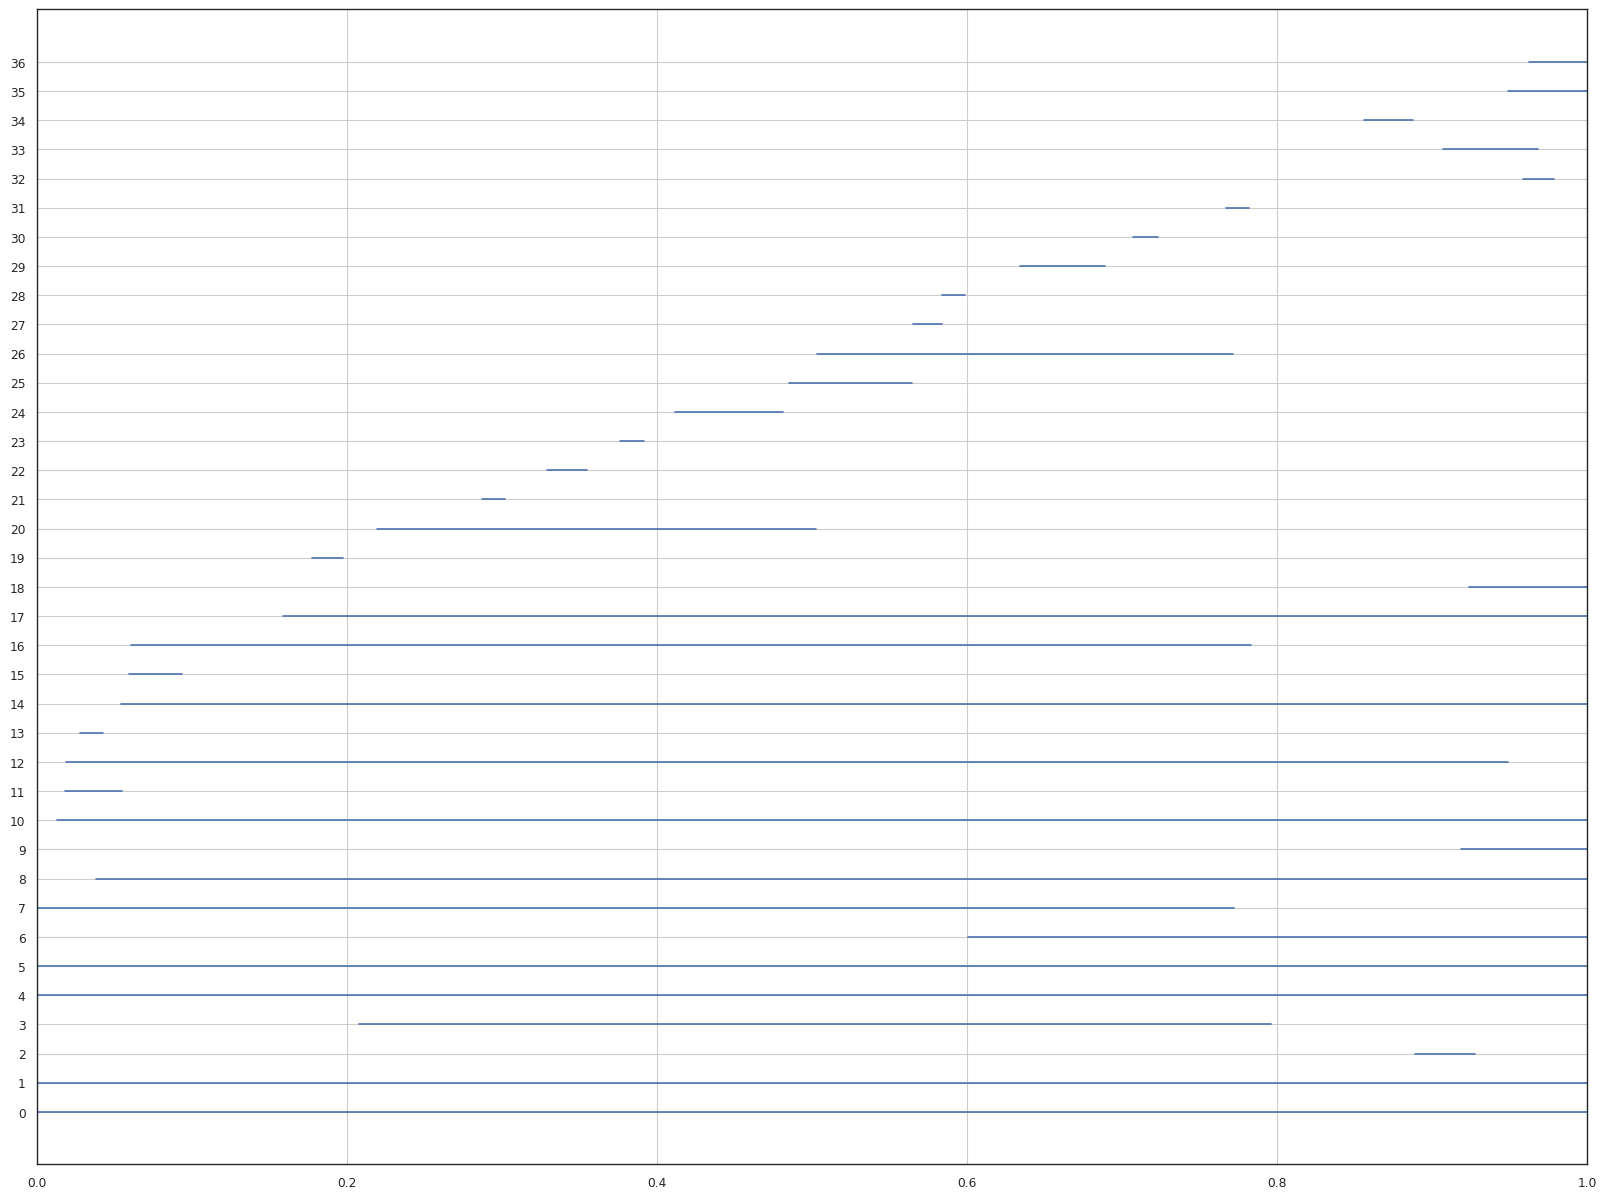

In [12]:
_ = plt.figure(figsize=(20,15))
for row_idx, row in df_id_start_stop.iterrows():
    plt.axhline(y=row_idx, xmin=row['min_idx']/total_idxs,xmax=row['max_idx']/total_idxs)
plt.yticks(range(df_id_start_stop.shape[0]), range(df_id_start_stop.shape[0]))
plt.grid() 

In [14]:
session_frames = df_tracking_new.index.values.tolist()
session_ids_covered = []
selected_frames = []
segments = []
segment_half_size = 50
for row_idx, row in df_id_start_stop.sort_values(by='total_idxs').iterrows():
    id_start, id_stop = row['min_idx'],row['max_idx']
    seg_mid = (id_start+id_stop)/2
    seg_start, seg_end = max(seg_mid-segment_half_size, 0), min(seg_mid+segment_half_size, total_idxs)
    is_id_covered = df_id_start_stop.apply(lambda row: (seg_end<=row['max_idx']) & (seg_start>=row['min_idx']),axis=1)
    seg_ids_covered = df_id_start_stop[is_id_covered]['id']
    new_ids_covered = [xr for xr in seg_ids_covered if xr not in session_ids_covered]
    if len(new_ids_covered)>0:        
        segment_frames = [xr for xr in session_frames if ((xr>=seg_start) and (xr<=seg_end))]
        selected_frames+=segment_frames
        segments.append((seg_start, seg_end, new_ids_covered, segment_frames))
        session_ids_covered+=new_ids_covered

sprint(segments)
    
    


List: segments


[
    (
        19868.5,
        19968.5,
        [0, 1, 3, 4, 5, 7, 8, 10, 12, 14, 16, 17, 20, 21],
        [
            19869,
            19872,
            19875,
            19878,
            19881,
            19884,
            19887,
            19890,
            19893,
            19896,
            19899,
            19902,
            19905,
            19908,
            19911,
            19914,
            19917,
            19920,
            19923,
            19926,
            19929,
            19932,
            19935,
            19938,
            19941,
            19944,
            19947,
            19950,
            19953,
            19956,
            19959,
            19962,
            19965,
            19968
        ]
    ),
    (
        39946.0,
        40046.0,
        [26, 28],
        [
            39948,
            39951,
            39954,
            39957,
            39960,
            39963,
            39966,
            39969,
            39972,
            39975,
            39978,
            39981,
            39984,
            39987,
            39990,
            39993,
            39996,
            39999,
            40002,
            40005,
            40008,
            40011,
            40014,
            40017,
            40020,
            40023,
            40026,
            40029,
            40032,
            40035,
            40038,
            40041,
            40044
        ]
    ),
    (
        52345.0,
        52445.0,
        [6, 31],
        [
            52347,
            52350,
            52353,
            52356,
            52359,
            52362,
            52365,
            52368,
            52371,
            52374,
            52377,
            52380,
            52383,
            52386,
            52389,
            52392,
            52395,
            52398,
            52401,
            52404,
            52407,
            52410,
            52413,
            52416,
            52419,
            52422,
            52425,
            52428,
            52431,
            52434,
            52437,
            52440,
            52443
        ]
    ),
    (
        2321.5,
        2421.5,
        [11, 13],
        [
            2322,
            2325,
            2328,
            2331,
            2334,
            2337,
            2340,
            2343,
            2346,
            2349,
            2352,
            2355,
            2358,
            2361,
            2364,
            2367,
            2370,
            2373,
            2376,
            2379,
            2382,
            2385,
            2388,
            2391,
            2394,
            2397,
            2400,
            2403,
            2406,
            2409,
            2412,
            2415,
            2418,
            2421
        ]
    ),
    (
        25909.0,
        26009.0,
        [23],
        [
            25911,
            25914,
            25917,
            25920,
            25923,
            25926,
            25929,
            25932,
            25935,
            25938,
            25941,
            25944,
            25947,
            25950,
            25953,
            25956,
            25959,
            25962,
            25965,
            25968,
            25971,
            25974,
            25977,
            25980,
            25983,
            25986,
            25989,
            25992,
            25995,
            25998,
            26001,
            26004,
            26007
        ]
    ),
    (
        48335.5,
        48435.5,
        [30],
        [
            48336,
            48339,
            48342,
            48345,
            48348,
            48351,
            48354,
            48357,
            48360,
            48363,
            48366,
            48369,
            48372,
            48375,
            48378,
            48381,
            48384,
            48387,

In [59]:
# for given frame ranges get video frames and tracking results
all_frames = mmcv.VideoReader(session_video_file)

required_frame_ids = np.unique(sorted(selected_frames))
frame_data_dict = {}

for frame_idx, frame_img in enumerate(all_frames):
    if (frame_idx in required_frame_ids) & (frame_idx%3==0):
        frame_data_dict[frame_idx] = frame_img
    if frame_idx%10000==0:
        print(f"Looped {frame_idx} images")
        



[h264 @ 0x1ab7847c0] error while decoding MB 126 36, bytestream -5
[h264 @ 0xdc512c0] error while decoding MB 126 36, bytestream -5
[h264 @ 0x1b2d0b200] error while decoding MB 65 27, bytestream -9
[h264 @ 0xc89f280] error while decoding MB 90 53, bytestream -9
[h264 @ 0xdc512c0] error while decoding MB 126 36, bytestream -5
[h264 @ 0x1b2d0b200] error while decoding MB 65 27, bytestream -9
[h264 @ 0xc89f280] error while decoding MB 90 53, bytestream -9


Looped 0 images


[h264 @ 0xe5dc400] error while decoding MB 71 30, bytestream -25
[h264 @ 0xc89f280] error while decoding MB 165 17, bytestream -8
[h264 @ 0xe5dc400] error while decoding MB 95 58, bytestream -5
[h264 @ 0x1b2d0b200] error while decoding MB 91 59, bytestream -7
[h264 @ 0x19e6eae80] error while decoding MB 90 33, bytestream -17
[h264 @ 0x18dff8280] error while decoding MB 159 18, bytestream -5
[h264 @ 0xc89f280] error while decoding MB 183 8, bytestream -5
[h264 @ 0xd86efc0] error while decoding MB 202 78, bytestream -9
[h264 @ 0x18ad04780] left block unavailable for requested intra4x4 mode -1
[h264 @ 0x18ad04780] error while decoding MB 0 61, bytestream 358176
[h264 @ 0x192843780] error while decoding MB 166 124, bytestream -5
[h264 @ 0x18dff8280] error while decoding MB 46 54, bytestream -9
[h264 @ 0x1b2d0b200] error while decoding MB 194 101, bytestream -5
[h264 @ 0x192861c80] error while decoding MB 182 10, bytestream -7
[h264 @ 0xc89f280] error while decoding MB 90 73, bytestream -9


Looped 10000 images


[h264 @ 0x1aa5d2840] error while decoding MB 207 105, bytestream -11
[h264 @ 0xc89f280] left block unavailable for requested intra4x4 mode -1
[h264 @ 0xc89f280] error while decoding MB 0 32, bytestream 460170
[h264 @ 0x1b2d0b200] cabac decode of qscale diff failed at 12 31
[h264 @ 0x1b2d0b200] error while decoding MB 12 31, bytestream 276481
[h264 @ 0xdc512c0] error while decoding MB 20 133, bytestream -9
[h264 @ 0x192843780] error while decoding MB 201 80, bytestream -5
[h264 @ 0xc8c6680] error while decoding MB 149 24, bytestream -5
[h264 @ 0xd86efc0] left block unavailable for requested intra4x4 mode -1
[h264 @ 0xd86efc0] error while decoding MB 0 35, bytestream 394977
[h264 @ 0x1b2d0b200] cabac decode of qscale diff failed at 219 27
[h264 @ 0x1b2d0b200] error while decoding MB 219 27, bytestream 381809
[h264 @ 0x192861c80] error while decoding MB 215 28, bytestream -5
[h264 @ 0x192843780] left block unavailable for requested intra mode
[h264 @ 0x192843780] error while decoding MB 0

Looped 20000 images


[h264 @ 0x192843780] cabac decode of qscale diff failed at 105 32
[h264 @ 0x192843780] error while decoding MB 105 32, bytestream 306418
[h264 @ 0xdc512c0] error while decoding MB 88 95, bytestream -5
[h264 @ 0x192861c80] cabac decode of qscale diff failed at 153 27
[h264 @ 0x192861c80] error while decoding MB 153 27, bytestream 423813
[h264 @ 0x19e6eae80] error while decoding MB 53 64, bytestream -7
[h264 @ 0x1b2d0b200] cabac decode of qscale diff failed at 127 39
[h264 @ 0x1b2d0b200] error while decoding MB 127 39, bytestream 278642
[h264 @ 0xdc512c0] left block unavailable for requested intra mode
[h264 @ 0xdc512c0] error while decoding MB 0 28, bytestream 471725
[h264 @ 0x1aa7b2680] error while decoding MB 196 98, bytestream -7
[h264 @ 0x17eaaa640] left block unavailable for requested intra4x4 mode -1
[h264 @ 0x17eaaa640] error while decoding MB 0 30, bytestream 495453
[h264 @ 0x1aa7b2680] error while decoding MB 24 86, bytestream -5
[h264 @ 0x18ad04780] cabac decode of qscale diff

Looped 30000 images


[h264 @ 0x1b2d0b200] cabac decode of qscale diff failed at 44 46
[h264 @ 0x1b2d0b200] error while decoding MB 44 46, bytestream 304272
[h264 @ 0x18dff8280] error while decoding MB 46 71, bytestream -5
[h264 @ 0x19e6eae80] error while decoding MB 198 9, bytestream -5
[h264 @ 0x1aa5d2840] error while decoding MB 36 71, bytestream -5
[h264 @ 0x18dff8280] left block unavailable for requested intra mode
[h264 @ 0x18dff8280] error while decoding MB 0 42, bytestream 390394
[h264 @ 0x19d5e7280] cabac decode of qscale diff failed at 25 32
[h264 @ 0x19d5e7280] error while decoding MB 25 32, bytestream 349913
[h264 @ 0xc8c6680] error while decoding MB 117 76, bytestream -5
[h264 @ 0x192861c80] cabac decode of qscale diff failed at 219 31
[h264 @ 0x192861c80] error while decoding MB 219 31, bytestream 308676
[h264 @ 0xc8c6680] cabac decode of qscale diff failed at 115 36
[h264 @ 0xc8c6680] error while decoding MB 115 36, bytestream 434230
[h264 @ 0x18dff8280] cabac decode of qscale diff failed at 

Looped 40000 images


[h264 @ 0x1aa7b2680] error while decoding MB 87 36, bytestream -5
[h264 @ 0x18ad04780] left block unavailable for requested intra mode
[h264 @ 0x18ad04780] error while decoding MB 0 78, bytestream 247730
[h264 @ 0x192843780] error while decoding MB 51 130, bytestream -5
[h264 @ 0xd86efc0] error while decoding MB 3 93, bytestream -34
[h264 @ 0x1aa7b2680] error while decoding MB 201 123, bytestream -5
[h264 @ 0xd86efc0] error while decoding MB 46 49, bytestream -19
[h264 @ 0xc89f280] cabac decode of qscale diff failed at 226 62
[h264 @ 0xc89f280] error while decoding MB 226 62, bytestream 325152
[h264 @ 0xc89f280] error while decoding MB 195 116, bytestream -5
[h264 @ 0xc98f4c0] error while decoding MB 198 99, bytestream -7
[h264 @ 0xdc512c0] error while decoding MB 203 56, bytestream -5
[h264 @ 0xe5dc400] error while decoding MB 218 131, bytestream -12
[h264 @ 0x19d5e7280] error while decoding MB 203 114, bytestream -5
[h264 @ 0x1aa5d2840] error while decoding MB 190 51, bytestream -9
[

Looped 50000 images


[h264 @ 0xe5dc400] cabac decode of qscale diff failed at 203 34
[h264 @ 0xe5dc400] error while decoding MB 203 34, bytestream 232642
[h264 @ 0x17eaaa640] error while decoding MB 120 85, bytestream -5
[h264 @ 0x19e6eae80] left block unavailable for requested intra mode
[h264 @ 0x19e6eae80] error while decoding MB 0 123, bytestream 36075
[h264 @ 0x1aa7b2680] error while decoding MB 203 34, bytestream -15
[h264 @ 0xd86efc0] error while decoding MB 10 87, bytestream -5


Looped 60000 images


[h264 @ 0x1aa5d2840] cabac decode of qscale diff failed at 182 38
[h264 @ 0x1aa5d2840] error while decoding MB 182 38, bytestream 366798
[h264 @ 0x19e6eae80] error while decoding MB 68 57, bytestream -9
[h264 @ 0xc8c6680] error while decoding MB 196 46, bytestream -9
[h264 @ 0xd86efc0] cabac decode of qscale diff failed at 229 24
[h264 @ 0xd86efc0] error while decoding MB 229 24, bytestream 316154
[h264 @ 0x1aa7b2680] cabac decode of qscale diff failed at 80 95
[h264 @ 0x1aa7b2680] error while decoding MB 80 95, bytestream 96365
[h264 @ 0xd86efc0] error while decoding MB 27 64, bytestream -9


Looped 70000 images


In [1]:
SOURCE_ROOT = '/home/prasoon/video_analysis/edusenseV2compute/compute/videoV3'
run_config = {
    'track_config':f'{SOURCE_ROOT}/configs/mmlab/ocsort_yolox_x_crowdhuman_mot17-private-half.py',
    'track_checkpoint':f'{SOURCE_ROOT}/models/mmlab/ocsort_yolox_x_crowdhuman_mot17-private-half_20220813_101618-fe150582.pth',
    'device':'cuda:1',
}


In [61]:
len(frame_data_dict.keys())

535

In [62]:
session_id_viz_dir = f'{id_viz_cache_root}/{sample_session_id}'
os.makedirs(session_id_viz_dir, exist_ok=True)


In [63]:
if tracking_model:
    printm("# Deleting Previous Model")
    del tracking_model
tracking_model = init_tracking_model(run_config['track_config'],
                                 run_config['track_checkpoint'],
                                 device=run_config['device'])
for seg_idx, (seg_start, seg_end, new_ids_covered, segment_frames) in enumerate(segments):
    seg_video_id = f'S{seg_idx}_{int(seg_start)}_{int(seg_end)}_{"_".join(map(str,new_ids_covered))}'
    match_cache_dir = f'{session_id_viz_dir}/{seg_video_id}'
    match_video_file = f'{session_id_viz_dir}/{seg_video_id}.mp4'
    if os.path.exists(match_video_file):
        continue
    print(match_video_file)
    os.makedirs(match_cache_dir, exist_ok=True)
    frame_num=0

    for frame_idx in segment_frames:
        frame_tracking_file = f"{session_frame_dir}/{frame_idx}.pb"
        if os.path.exists(frame_tracking_file) and (frame_idx in frame_data_dict):
            frame_file_out = os.path.join(match_cache_dir, f'{frame_num:06d}.jpg')
            frame_num+=1
            if os.path.exists(frame_file_out):
                continue
            frame_tracking_results = pickle.load(open(frame_tracking_file,"rb"))[1]
            for person_idx in range(len(frame_tracking_results)):
                old_id= int(frame_tracking_results[person_idx]['track_id'])
                frame_tracking_results[person_idx]['track_id'] =old_to_new_id_map[old_id]
            frame_img = deepcopy(frame_data_dict[frame_idx])
            if len(frame_tracking_results)>0:
                frame_tracking_results = {
                    'track_bboxes':[np.array([[xr['track_id']]+xr['bbox'].tolist() for xr in frame_tracking_results])],
                    'det_bboxes':[np.array([xr['bbox'].tolist() for xr in frame_tracking_results])]}
                frame_track_img = tracking_model.show_result(
                    frame_img,
                    frame_tracking_results,
                    thickness=5,
                    font_scale=.5,
                    score_thr=0.1,
                    show=False,
                    wait_time=int(1000. / 5),
                    out_file=frame_file_out,
                    backend='cv2')
            else:
                cv2.imwrite(frame_file_out,frame_img)
    
    #         break
    # break
    mmcv.frames2video(match_cache_dir, match_video_file, fps=5, fourcc='mp4v')
    print(f"Done for segment {seg_video_id}")
    # break
    
    

# Deleting Previous Model

2023-08-11 16:16:16,104 - mmdet - INFO - image shape: height=800, width=1440 in YOLOX.__init__
2023-08-11 16:16:16,263 - mmtrack - INFO - initialize YOLOX with init_cfg {'type': 'Pretrained', 'checkpoint': 'https://download.openmmlab.com/mmdetection/v2.0/yolox/yolox_x_8x8_300e_coco/yolox_x_8x8_300e_coco_20211126_140254-1ef88d67.pth'}
2023-08-11 16:16:16,264 - mmcv - INFO - load model from: https://download.openmmlab.com/mmdetection/v2.0/yolox/yolox_x_8x8_300e_coco/yolox_x_8x8_300e_coco_20211126_140254-1ef88d67.pth
2023-08-11 16:16:16,264 - mmcv - INFO - load checkpoint from http path: https://download.openmmlab.com/mmdetection/v2.0/yolox/yolox_x_8x8_300e_coco/yolox_x_8x8_300e_coco_20211126_140254-1ef88d67.pth
2023-08-11 16:16:18,331 - mmcv - WARNING - The model and loaded state dict do not match exactly

size mismatch for bbox_head.multi_level_conv_cls.0.weight: copying a param with shape torch.Size([80, 320, 1, 1]) from checkpoint, the shape in current model is torch.Size([1, 320, 1, 

load checkpoint from local path: /home/prasoon/video_analysis/edusenseV2compute/compute/videoV3/models/mmlab/ocsort_yolox_x_crowdhuman_mot17-private-half_20220813_101618-fe150582.pth
The model and loaded state dict do not match exactly

unexpected key in source state_dict: ema_detector_backbone_stem_conv_conv_weight, ema_detector_backbone_stem_conv_bn_weight, ema_detector_backbone_stem_conv_bn_bias, ema_detector_backbone_stem_conv_bn_running_mean, ema_detector_backbone_stem_conv_bn_running_var, ema_detector_backbone_stem_conv_bn_num_batches_tracked, ema_detector_backbone_stage1_0_conv_weight, ema_detector_backbone_stage1_0_bn_weight, ema_detector_backbone_stage1_0_bn_bias, ema_detector_backbone_stage1_0_bn_running_mean, ema_detector_backbone_stage1_0_bn_running_var, ema_detector_backbone_stage1_0_bn_num_batches_tracked, ema_detector_backbone_stage1_1_main_conv_conv_weight, ema_detector_backbone_stage1_1_main_conv_bn_weight, ema_detector_backbone_stage1_1_main_conv_bn_bias, ema_detector

In [65]:
id_viz_cache_root

'/mnt/ci-nas-cache/edulyzeV2/cache_compute_4//analysis_tracking/session_matching_info'

# Run visualization code on all sessions

In [ ]:
SOURCE_ROOT = '/home/prasoon/video_analysis/edusenseV2compute/compute/videoV3'
run_config = {
    'track_config':f'{SOURCE_ROOT}/configs/mmlab/ocsort_yolox_x_crowdhuman_mot17-private-half.py',
    'track_checkpoint':f'{SOURCE_ROOT}/models/mmlab/ocsort_yolox_x_crowdhuman_mot17-private-half_20220813_101618-fe150582.pth',
    'device':'cuda:1',
}

for course_idx, course in enumerate(frame_file_data):
    for session_idx, session_id in enumerate(frame_file_data[course]):
        session_id_viz_dir = f'{id_viz_cache_root}/{session_id}'
        if not os.path.exists(session_id_viz_dir):
            
            session_tracking_cache_file = f"{track_analysis_session_data}/{session_id}.pb"
            session_preprocessed_id_map_file = f"{postprocessed_id_map_data_dir}/{session_id}.pb"
            session_frame_dir = f'/mnt/ci-nas-cache/edulyzeV2/pose_face_gaze_emb/{course}/{session_id}'
            session_video_file = f'/mnt/ci-nas-classes/classinsight/2019S/video_backup/{session_id.split("-front")[0]}/{session_id}.avi'
            printm(f'# {course_idx}-{course}, session:{session_idx}-{session_id}')
            printm("## Get preprocessed tracking ids...")
            
            df_tracking_new = pickle.load(open(session_tracking_cache_file,"rb")).transpose()
            old_to_new_id_map = pickle.load(open(session_preprocessed_id_map_file,"rb"))
            total_idxs = df_tracking_new.index.max()
            for old_id in old_to_new_id_map:
                new_id = old_to_new_id_map[old_id]
                if not new_id==10000:
                    new_id_col = f'N{new_id}'
                    if new_id_col not in df_tracking_new:
                        df_tracking_new[new_id_col] = None
                    df_tracking_new[new_id_col] =  df_tracking_new[old_id].where(~df_tracking_new[old_id].isnull(), df_tracking_new[old_id])
                df_tracking_new = df_tracking_new.drop(old_id, axis=1)

            col_start_stop_idxs = []
            for col in df_tracking_new.columns:
                one_idxs = df_tracking_new.index[np.where(df_tracking_new[col]==1)[0]].values
                col_start_stop_idxs.append([col, one_idxs.min(), one_idxs.max()])
            df_id_start_stop = pd.DataFrame(col_start_stop_idxs, columns=['id','min_idx','max_idx'])
            df_id_start_stop['total_idxs'] = df_id_start_stop['max_idx']-df_id_start_stop['min_idx']
            df_id_start_stop['id'] = df_id_start_stop['id'].apply(lambda x: int(x[1:]))
            
            printm(f"## Get segments to visualize from {df_tracking_new.shape[1]} tracking ids...")
            session_frames = df_tracking_new.index.values.tolist()
            session_ids_covered = []
            selected_frames = []
            segments = []
            segment_half_size = 50
            for row_idx, row in df_id_start_stop.sort_values(by='total_idxs').iterrows():
                id_start, id_stop = row['min_idx'],row['max_idx']
                seg_mid = (id_start+id_stop)/2
                seg_start, seg_end = max(seg_mid-segment_half_size, 0), min(seg_mid+segment_half_size, total_idxs)
                is_id_covered = df_id_start_stop.apply(lambda row: (seg_end<=row['max_idx']) & (seg_start>=row['min_idx']),axis=1)
                seg_ids_covered = df_id_start_stop[is_id_covered]['id']
                new_ids_covered = [xr for xr in seg_ids_covered if xr not in session_ids_covered]
                if len(new_ids_covered)>0:        
                    segment_frames = [xr for xr in session_frames if ((xr>=seg_start) and (xr<=seg_end))]
                    selected_frames+=segment_frames
                    segments.append((seg_start, seg_end, new_ids_covered, segment_frames))
                    session_ids_covered+=new_ids_covered
            printm(f"## Got {len(segments)} segments to visualize...")

            printm(f"## Get video frames from session video file for segment frames...")
            all_frames = mmcv.VideoReader(session_video_file)
            required_frame_ids = np.unique(sorted(selected_frames))
            frame_data_dict = dict()
            
            for frame_idx, frame_img in enumerate(all_frames):
                if (frame_idx in required_frame_ids) & (frame_idx%3==0):
                    frame_data_dict[frame_idx] = frame_img
                if frame_idx%1000==0:
                    print(f"Looped {frame_idx} images")
            printm(f"## Got {len(frame_data_dict.keys())} video frames from session video file...")

            printm(f"## Create segment videos with new tracking ids...")
            os.makedirs(session_id_viz_dir, exist_ok=True)
            tracking_model = init_tracking_model(run_config['track_config'],
                                             run_config['track_checkpoint'],
                                             device=run_config['device'])
            for seg_idx, (seg_start, seg_end, new_ids_covered, segment_frames) in enumerate(segments):
                seg_video_id = f'S{seg_idx}_{int(seg_start)}_{int(seg_end)}_{"_".join(map(str,new_ids_covered))}'
                match_cache_dir = f'{session_id_viz_dir}/{seg_video_id}'
                match_video_file = f'{session_id_viz_dir}/{seg_video_id}.mp4'
                if os.path.exists(match_video_file):
                    continue
                print(match_video_file)
                os.makedirs(match_cache_dir, exist_ok=True)
                frame_num=0
            
                for frame_idx in segment_frames:
                    frame_tracking_file = f"{session_frame_dir}/{frame_idx}.pb"
                    if os.path.exists(frame_tracking_file) and (frame_idx in frame_data_dict):
                        frame_file_out = os.path.join(match_cache_dir, f'{frame_num:06d}.jpg')
                        frame_num+=1
                        if os.path.exists(frame_file_out):
                            continue
                        frame_tracking_results = pickle.load(open(frame_tracking_file,"rb"))[1]
                        for person_idx in range(len(frame_tracking_results)):
                            old_id= int(frame_tracking_results[person_idx]['track_id'])
                            frame_tracking_results[person_idx]['track_id'] =old_to_new_id_map[old_id]
                        frame_img = deepcopy(frame_data_dict[frame_idx])
                        if len(frame_tracking_results)>0:
                            frame_tracking_results = {
                                'track_bboxes':[np.array([[xr['track_id']]+xr['bbox'].tolist() for xr in frame_tracking_results])],
                                'det_bboxes':[np.array([xr['bbox'].tolist() for xr in frame_tracking_results])]}
                            frame_track_img = tracking_model.show_result(
                                frame_img,
                                frame_tracking_results,
                                thickness=5,
                                font_scale=.5,
                                score_thr=0.1,
                                show=False,
                                wait_time=int(1000. / 5),
                                out_file=frame_file_out,
                                backend='cv2')
                        else:
                            cv2.imwrite(frame_file_out,frame_img)
                mmcv.frames2video(match_cache_dir, match_video_file, fps=5, fourcc='mp4v')
                print(f"Done for segment {seg_video_id}")
            del tracking_model
            printm(f"## Created Segment Visualization for session: {course_idx}-{course}, session:{session_idx}-{session_id} from {len(old_to_new_id_map.keys())} to {df_id_start_stop.shape[0]} ids")
        else:
            printm(f"## Segement visualization directory EXISTS for session: {course_idx}-{course}, session:{session_idx}-{session_id}")
            
        
        

# 0-05410A, session:0-classinsight-cmu_05410A_ghc_4301_201902181500-front

## Get preprocessed tracking ids...

In [6]:
session_video_file

'/mnt/ci-nas-classes/classinsight/2019S/video_backup/classinsight-cmu_05410A_ghc_4301_201902251500/classinsight-cmu_05410A_ghc_4301_201902251500-front.avi'